# Import all required modules

In [1]:
# Modules for calculations
import numpy as np
import scipy
import torch
import qutip as qt

# Modules for plotting
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.cm import plasma

# SAFE-GRAPE Algorithm

## Setting the hyperparameters

In [2]:
# Set number of pulses in composite pulse
TIME_STEPS = 100 

# Define discretized composite search space
EPSILON_RANGE = 0.3 
EPSILON_N = 11
F_RANGE = 0.3
F_N = 11

# Set Rabi drive strength
OMEGA = 200e6 #Mrad/s

# Set target operation
# In this example, we want to implement a pi-X gate
THETA = torch.tensor(np.pi)
PHI = torch.tensor(0)

# Choose an initial guess for the trainable parameters t_i and phi_i (i in [1..N_p])
# We take reduced CORPSE in BB1 as our initial guess
INITIAL_GUESS = 'rCinBB' 
t_ig = torch.zeros(TIME_STEPS, dtype=torch.float64)
phi_ig = torch.zeros(TIME_STEPS, dtype=torch.float64)
if INITIAL_GUESS == 'rCinBB':
    PI = torch.tensor(np.pi)
    k = torch.arcsin(torch.sin(torch.tensor(THETA / 2)) / 2)
    theta_ig_rCinBB = [
        PI,
        2 * PI,
        PI,
        2 * PI + THETA / 2 - k,
        2 * PI - 2 * k,
        THETA / 2 - k]
    phi_ig_rCinBB = [
        PHI + torch.arccos(torch.tensor(-THETA / 4 / PI)),
        PHI + 3 * torch.arccos(torch.tensor(-THETA / 4 / PI)),
        PHI + torch.arccos(torch.tensor(-THETA / 4 / PI)),
        PHI,
        PHI + PI,
        PHI]
    total_theta = sum(theta_ig_rCinBB)
    total_time = total_theta/OMEGA
    for i in range(6):
        start_idx = int(np.rint(sum(theta_ig_rCinBB[:i])/total_theta * TIME_STEPS))
        end_idx = int(np.rint(sum(theta_ig_rCinBB[:i+1])/total_theta * TIME_STEPS))
        t_ig[start_idx:end_idx] = total_time / TIME_STEPS
        phi_ig[start_idx:end_idx] = phi_ig_rCinBB[i]

# Define parameters for the sigmoid reparametrization of t
t_min = 1e-9
t_max = 1e-8
# We also define a help function to retrieve the actual t after sigmoid reparametrization
def get_t(raw_t):
    scaled_t = 1/(1+np.exp(-raw_t))  # in [0,1]
    return t_min + (t_max - t_min)*scaled_t

/var/folders/q0/7f04j2qd3gl8slmzfbwlpdhr0000gn/T/ipykernel_63977/1569617681.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k = torch.arcsin(torch.sin(torch.tensor(THETA / 2)) / 2)
/var/folders/q0/7f04j2qd3gl8slmzfbwlpdhr0000gn/T/ipykernel_63977/1569617681.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PHI + torch.arccos(torch.tensor(-THETA / 4 / PI)),
/var/folders/q0/7f04j2qd3gl8slmzfbwlpdhr0000gn/T/ipykernel_63977/1569617681.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PHI + 3 * torch.arccos(torch.tensor(-THETA / 4 / 

## Defining the PyTorch module

In [3]:
class SAFE_GRAPE(torch.nn.Module):  
  def __init__(self, t_ig, phi_ig):
    super(SAFE_GRAPE, self).__init__()

    self.sigma_x = torch.tensor([[0, 1], [1, 0]], dtype=torch.complex128)
    self.sigma_y = torch.tensor([[0, -1j], [1j, 0]], dtype=torch.complex128)
    self.sigma_z = torch.tensor([[1, 0], [0, -1]], dtype=torch.complex128)

    self.phi = torch.nn.Parameter(phi_ig.clone().detach(), requires_grad=True)
    self.raw_t = torch.nn.Parameter(torch.logit(torch.clamp((t_ig - 1e-9) / (1e-8 - 1e-9),min=1e-6,max=1 - 1e-6)),requires_grad=True) # Sigmoid reparameterization

  # Define function to retrieve actual t from sigmoid reparametrization
  def get_t(self, t_max = t_max, t_min = t_min):
    scaled_t = torch.sigmoid(self.raw_t)  # lies in [0,1]
    return t_min + (t_max - t_min)*scaled_t 

  # Apply Gaussian weights to prioritize the center of the composite search space
  def apply_gaussian_weights(self, matrix, sigma_epsilon, sigma_f, normalize=True):
    M, N = matrix.shape
    y_coords, x_coords = torch.meshgrid(
        torch.arange(M, dtype=matrix.dtype, device=matrix.device),
        torch.arange(N, dtype=matrix.dtype, device=matrix.device),
        indexing='ij')
    center_x = (N - 1) / 2.0
    center_y = (M - 1) / 2.0
    
    gauss_mask = torch.exp(-(((x_coords - center_x) ** 2) / (2.0 * sigma_epsilon ** 2) + ((y_coords - center_y) ** 2) / (2.0 * sigma_f ** 2)))

    if normalize: # Normalize mask so that its sum is N*M
        gauss_mask /= gauss_mask.sum()
        gauss_mask *= (M * N)
        
    return matrix * gauss_mask

  # Define a real gate U(theta, phi) with amplitude error epsilon and frequency error f
  def V(self, t, phi, f, eps):
    return torch.matrix_exp(-1j * OMEGA * t / 2 * ( (1 + eps) *
            ( torch.cos(phi) * self.sigma_x + torch.sin(phi) * self.sigma_y ) + f * self.sigma_z))

  # Define an ideal gate U(theta, phi)
  def U(self, theta, phi):
    return torch.matrix_exp(-1j * theta / 2 * (torch.cos(phi) * self.sigma_x + torch.sin(phi) * self.sigma_y))

  # Define a function to compute the average gate fidelity between two gates
  def average_gate_fidelity(self, U, V):
    return torch.abs(torch.trace(torch.matmul(torch.conj(U).t(), V)) / 2) # Assuming U and V are 2x2 matrices

  # For each point (epsilon, f) in the composite search space, compute the average gate infidelity between the ideal target gate and the real composite pulse sequence
  # The global optimization function is then the sum of all those values, corrected with the corresponding Gaussian weights
  def forward(self):
    t_actual = self.get_t() 
    infidelity = torch.zeros((EPSILON_N, F_N))
    for i, epsilon in enumerate(torch.linspace(-EPSILON_RANGE, EPSILON_RANGE, EPSILON_N)):
      for j, f in enumerate(torch.linspace(-F_RANGE, F_RANGE, F_N)):
        sequence = self.V(torch.tensor(0), torch.tensor(0), 0, 0)
        for n in range(TIME_STEPS):
          sequence = torch.matmul(self.V(t_actual[n], self.phi[n], f, epsilon), sequence)
        infidelity[i, j] = 1 - self.average_gate_fidelity(sequence, self.U(THETA, PHI))
    weighted_infidelity = self.apply_gaussian_weights(matrix = infidelity, sigma_epsilon = EPSILON_N/3, sigma_f = F_N/3)
    return torch.sum(weighted_infidelity)

## Plotting tools

In [4]:
# Define a class for generating all different plots
class CompositePulsePlots:
  def __init__(self, theta_target, phi_target, initial_t, initial_phi, final_t, final_phi):
    self.theta_target = theta_target
    self.phi_target = phi_target
    self.initial_t = initial_t
    self.initial_phi = initial_phi
    self.final_t = final_t
    self.final_phi = final_phi

    self.sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
    self.sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    self.sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)

    self.fidelity_initial = None
    self.fidelity_final = None

  # Define a real gate U(theta, phi) with amplitude error epsilon and frequency error f
  def V(self, t, phi, f, eps):
    return scipy.linalg.expm(-1j * OMEGA * t / 2 * ( (1 + eps) * ( np.cos(phi) * self.sigma_x + np.sin(phi) * self.sigma_y ) + f * self.sigma_z ))

  # Define an ideal gate U(theta, phi)
  def U(self, theta, phi):
    return scipy.linalg.expm(-1j * theta / 2 * ( np.cos(phi) * self.sigma_x + np.sin(phi) * self.sigma_y ))

  # Define a function to compute the average gate fidelity between two gates
  def average_gate_fidelity(self, U, V):
    dim = U.shape[0]  # Assuming U is a square matrix
    F_avg = np.abs(np.trace(np.matmul(np.conj(U).T, V)) / dim)
    return F_avg
      
  # For each point (epsilon, f) in the composite search space, compute the average gate infidelity between the ideal target gate and the real optimized composite pulse sequence
  def compute_fidelity_map_final(self, epsilon_range, epsilon_n, f_range, f_n):
    self.fidelity_final = np.zeros((epsilon_n, f_n))
    for i,epsilon in enumerate(np.linspace(-epsilon_range,epsilon_range,epsilon_n)):
      for j,f in enumerate(np.linspace(-f_range,f_range,f_n)):
        sequence = self.V(0,0,0,0)
        for n in range(TIME_STEPS):
          sequence = np.matmul(self.V(self.final_t[n], self.final_phi[n], f, epsilon), sequence)
        self.fidelity_final[i][j] = self.average_gate_fidelity(sequence, self.U(self.theta_target, self.phi_target))
    return self.fidelity_final

  # For each point (epsilon, f) in the composite search space, compute the average gate infidelity between the ideal target gate and the real initial composite pulse sequence
  def compute_fidelity_map_initial(self, epsilon_range, epsilon_n, f_range, f_n):
    self.fidelity_initial = np.zeros((epsilon_n, f_n))
    for i,epsilon in enumerate(np.linspace(-epsilon_range,epsilon_range,epsilon_n)):
      for j,f in enumerate(np.linspace(-f_range,f_range,f_n)):
        sequence = self.V(0,0,0,0)
        for n in range(TIME_STEPS):
          sequence = np.matmul(self.V(self.initial_t[n], self.initial_phi[n], f, epsilon), sequence)
        self.fidelity_initial[i][j] = self.average_gate_fidelity(sequence, self.U(self.theta_target, self.phi_target))
    return self.fidelity_initial

  def scientific_notation(self, num):
    exponent = np.floor(np.log10(num))
    mantissa = num / 10**exponent
    return f'${mantissa:.0f} \\times 10^{{{int(exponent)}}}$'

  # Compute, plot and save the fidelity heatmap for the initial composite pulse sequence, with indication of contours at certain fidelities
  def fidelity_heatmap_initial(self, epsilon_range, epsilon_n, f_range, f_n, min_fidelity = None, max_fidelity = None):
    self.compute_fidelity_map_initial(epsilon_range, epsilon_n, f_range, f_n)
    colors = ['#FFFFFF', '#BFBFBF', '#808080', '#404040', '#000000']
    levels = [0.99, 0.995, 0.999,0.9995,0.9999]
    colors = [colors[i] for i in range(len(levels)) if np.max(self.fidelity_initial) > levels[i] > np.min(self.fidelity_initial)]
    levels = [i for i in levels if np.max(self.fidelity_initial) > i > np.min(self.fidelity_initial)]
    fig, ax = plt.subplots(figsize=(10, 8))
    if (min_fidelity, max_fidelity) == (None, None):
      cax = ax.imshow(self.fidelity_initial, interpolation='nearest', cmap='plasma', origin='lower')
    elif min_fidelity == None:
      cax = ax.imshow(self.fidelity_initial, interpolation='nearest', cmap='plasma', origin='lower', vmax=max_fidelity)
    elif max_fidelity == None:
      cax = ax.imshow(self.fidelity_initial, interpolation='nearest', cmap='plasma', origin='lower', vmin=min_fidelity)
    else:
      cax = ax.imshow(self.fidelity_initial, interpolation='nearest', cmap='plasma', origin='lower', vmin=min_fidelity, vmax=max_fidelity)
    cbar = fig.colorbar(cax)
    contours = ax.contour(self.fidelity_initial, levels=levels, colors=colors)
    for i in range(len(levels)):
        ax.contour(self.fidelity_initial, levels=[levels[i]], colors=[colors[i]])
    #ax.legend([contours.collections[i] for i in range(len(levels))], [f'{level}' for level in levels], fontsize = 16)
    f_ticks = [0, f_n//2, f_n-1] 
    eps_ticks = [0, epsilon_n//2, epsilon_n-1] 
    ax.set_xticks(f_ticks)
    ax.set_yticks(eps_ticks)
    ax.set_xticklabels([f'{np.linspace(-f_range,f_range,f_n)[i]:.2f}' for i in f_ticks], fontsize = 16)
    ax.set_yticklabels([f'{np.linspace(-epsilon_range,epsilon_range,epsilon_n)[j]:.2f}' for j in eps_ticks], fontsize = 16)
    ax.set_xlabel('f', fontsize = 20)
    ax.set_ylabel('epsilon', fontsize = 20)
    ax.set_title('Gate Fidelity Heatmap for rCinBB', fontsize = 20)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    cbar.ax.tick_params(labelsize=16)
    plt.savefig("fidelity_heatmap_initial.svg")   # or .pdf / .eps
    plt.show()

  # Compute, plot and save the fidelity heatmap for the final composite pulse sequence, with indication of contours at certain fidelities
  def fidelity_heatmap_final(self, epsilon_range, epsilon_n, f_range, f_n, min_fidelity = None, max_fidelity = None):
    self.compute_fidelity_map_final(epsilon_range, epsilon_n, f_range, f_n)
    colors = ['#FFFFFF', '#BFBFBF', '#808080', '#404040', '#000000']
    levels = [0.99, 0.995, 0.999,0.9995,0.9999]
    colors = [colors[i] for i in range(len(levels)) if np.max(self.fidelity_final) > levels[i] > np.min(self.fidelity_final)]
    levels = [i for i in levels if np.max(self.fidelity_final) > i > np.min(self.fidelity_final)]
    fig, ax = plt.subplots(figsize=(10, 8))
    if (min_fidelity, max_fidelity) == (None, None):
      cax = ax.imshow(self.fidelity_final, interpolation='nearest', cmap='plasma', origin='lower')
    elif min_fidelity == None:
      cax = ax.imshow(self.fidelity_final, interpolation='nearest', cmap='plasma', origin='lower', vmax=max_fidelity)
    elif max_fidelity == None:
      cax = ax.imshow(self.fidelity_final, interpolation='nearest', cmap='plasma', origin='lower', vmin=min_fidelity)
    else:
      cax = ax.imshow(self.fidelity_final, interpolation='nearest', cmap='plasma', origin='lower', vmin=min_fidelity, vmax=max_fidelity)
    cbar = fig.colorbar(cax)
    contours = ax.contour(self.fidelity_final, levels=levels, colors=colors)
    for i in range(len(levels)):
        ax.contour(self.fidelity_final, levels=[levels[i]], colors=[colors[i]])
    #ax.legend([contours.collections[i] for i in range(len(levels))], [f'{level}' for level in levels], fontsize = 16)
    f_ticks = [0, f_n//2, f_n-1]
    eps_ticks = [0, epsilon_n//2, epsilon_n-1] 
    ax.set_xticks(f_ticks)
    ax.set_yticks(eps_ticks)
    ax.set_xticklabels([f'{np.linspace(-f_range,f_range,f_n)[i]:.2f}' for i in f_ticks], fontsize = 16)
    ax.set_yticklabels([f'{np.linspace(-epsilon_range,epsilon_range,epsilon_n)[j]:.2f}' for j in eps_ticks], fontsize = 16)
    ax.set_xlabel('f', fontsize = 20)
    ax.set_ylabel('epsilon', fontsize = 20)
    ax.set_title('Gate Fidelity Heatmap for GRAPE on rCinBB', fontsize = 20)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    cbar.ax.tick_params(labelsize=16)
    plt.savefig("fidelity_heatmap_final.svg")   # or .pdf / .eps
    plt.show()

  # Compute, plot and save the infidelity heatmap for the initial composite pulse sequence, with indication of contours at certain fidelities and logarithmic scale
  def infidelity_heatmap_initial(self, epsilon_range, epsilon_n, f_range, f_n, min_infidelity = None, max_infidelity = None):
    self.compute_fidelity_map_initial(epsilon_range, epsilon_n, f_range, f_n)
    colors = ['#FFFFFF', '#BFBFBF', '#808080', '#404040', '#000000']
    levels = [0.0001, 0.0005, 0.001, 0.005, 0.01]
    colors = [colors[i] for i in range(len(levels)) if np.max(self.fidelity_initial) > 1-levels[i] > np.min(self.fidelity_initial)]
    levels = [i for i in levels if np.max(self.fidelity_initial) > 1-i > np.min(self.fidelity_initial)]
    fig, ax = plt.subplots(figsize=(10, 8))
    if min_infidelity is None:
        min_infidelity = np.min(1-self.fidelity_initial[1-self.fidelity_initial > 0])
    if max_infidelity is None:
        max_infidelity = np.max(1-self.fidelity_initial)
    norm = LogNorm(vmin=min_infidelity, vmax=max_infidelity)
    cax = ax.imshow(1-self.fidelity_initial, interpolation='nearest', cmap='plasma', origin='lower', norm=norm)
    cbar = fig.colorbar(cax)
    contours = ax.contour(1-self.fidelity_initial, levels=levels, colors=colors)
    for i in range(len(levels)):
        ax.contour(1-self.fidelity_initial, levels=[levels[i]], colors=[colors[i]])
    #scientific_levels = [self.scientific_notation(level) for level in levels]
    #ax.legend([contours.collections[i] for i in range(len(levels))], scientific_levels, fontsize = 16)
    f_ticks = [0, f_n//2, f_n-1]
    eps_ticks = [0, epsilon_n//2, epsilon_n-1]
    ax.set_xticks(f_ticks)
    ax.set_yticks(eps_ticks)
    ax.set_xticklabels([f'{np.linspace(-f_range,f_range,f_n)[i]:.2f}' for i in f_ticks], fontsize = 16)
    ax.set_yticklabels([f'{np.linspace(-epsilon_range,epsilon_range,epsilon_n)[j]:.2f}' for j in eps_ticks], fontsize = 16)
    ax.set_xlabel('f', fontsize = 20)
    ax.set_ylabel('epsilon', fontsize = 20)
    ax.set_title('Gate Infidelity Heatmap for rCinBB', fontsize = 20)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    cbar.ax.tick_params(labelsize=16)
    plt.savefig("infidelity_heatmap_initial.svg")   # or .pdf / .eps
    plt.show()

  # Compute, plot and save the infidelity heatmap for the final composite pulse sequence, with indication of contours at certain fidelities and logarithmic scale
  def infidelity_heatmap_final(self, epsilon_range, epsilon_n, f_range, f_n, min_infidelity = None, max_infidelity = None):
    self.compute_fidelity_map_final(epsilon_range, epsilon_n, f_range, f_n)
    colors = ['#FFFFFF', '#BFBFBF', '#808080', '#404040', '#000000']
    levels = [0.0001, 0.0005, 0.001, 0.005, 0.01]
    colors = [colors[i] for i in range(len(levels)) if np.max(self.fidelity_final) > 1-levels[i] > np.min(self.fidelity_final)]
    levels = [i for i in levels if np.max(self.fidelity_final) > 1-i > np.min(self.fidelity_final)]
    fig, ax = plt.subplots(figsize=(10, 8))
    if min_infidelity is None:
        min_infidelity = np.min(1-self.fidelity_final[1-self.fidelity_final > 0])
    if max_infidelity is None:
        max_infidelity = np.max(1-self.fidelity_final)
    norm = LogNorm(vmin=min_infidelity, vmax=max_infidelity)
    cax = ax.imshow(1-self.fidelity_final, interpolation='nearest', cmap='plasma', origin='lower', norm=norm)
    cbar = fig.colorbar(cax)
    contours = ax.contour(1-self.fidelity_final, levels=levels, colors=colors)
    for i in range(len(levels)):
        ax.contour(1-self.fidelity_final, levels=[levels[i]], colors=[colors[i]])
    #scientific_levels = [self.scientific_notation(level) for level in levels]
    #ax.legend([contours.collections[i] for i in range(len(levels))], scientific_levels, fontsize = 16)
    f_ticks = [0, f_n//2, f_n-1]
    eps_ticks = [0, epsilon_n//2, epsilon_n-1]
    ax.set_xticks(f_ticks)
    ax.set_yticks(eps_ticks)
    ax.set_xticklabels([f'{np.linspace(-f_range,f_range,f_n)[i]:.2f}' for i in f_ticks], fontsize = 16)
    ax.set_yticklabels([f'{np.linspace(-epsilon_range,epsilon_range,epsilon_n)[j]:.2f}' for j in eps_ticks], fontsize = 16)
    ax.set_xlabel('f', fontsize = 20)
    ax.set_ylabel('epsilon', fontsize = 20)
    ax.set_title('Gate Infidelity Heatmap for GRAPE on rCinBB', fontsize = 20)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    cbar.ax.tick_params(labelsize=16)
    plt.savefig("infidelity_heatmap_final.svg")   # or .pdf / .eps
    plt.show()

  # Save and show theta(t) for the pulse before and after optimization with SAFE-GRAPE
  def show_pulse(self, n_timesteps_for_plotting = 10 * TIME_STEPS):
    total_time_initial = np.sum(self.initial_t)
    total_time_final = np.sum(self.final_t)
    total_time = max(total_time_initial, total_time_final)
    time_plotting = np.linspace(0, total_time, n_timesteps_for_plotting, endpoint = True)
    initial_phi_plotting = np.zeros(len(time_plotting))
    final_phi_plotting = np.zeros(len(time_plotting))
    for i in range(TIME_STEPS):
        start_idx_initial = int(np.rint(sum(self.initial_t[:i])/total_time * n_timesteps_for_plotting))
        end_idx_initial = int(np.rint(sum(self.initial_t[:i+1])/total_time * n_timesteps_for_plotting))
        initial_phi_plotting[start_idx_initial:end_idx_initial] = self.initial_phi[i]
        start_idx_final = int(np.rint(sum(self.final_t[:i])/total_time * n_timesteps_for_plotting))
        end_idx_final = int(np.rint(sum(self.final_t[:i+1])/total_time * n_timesteps_for_plotting))
        final_phi_plotting[start_idx_final:end_idx_final] = self.final_phi[i]
    plt.figure(figsize=(12, 3))
    plt.plot(time_plotting[:end_idx_initial], initial_phi_plotting[:end_idx_initial], color = plasma(0.25), label='rCinBB')
    plt.plot(time_plotting[:end_idx_final], final_phi_plotting[:end_idx_final], color = plasma(0.75), label='GRAPE on rCinBB')
    plt.title('Rabi drive = ' + str(OMEGA * 1e-6) + ' MHz')
    plt.xlabel('time [s]')
    plt.ylabel('Phi [rad]')
    plt.legend()
    plt.savefig("PulseSequence.svg")   # or .pdf / .eps
    plt.show()

  # Save and show the action of the pulse before SAFE-GRAPE optimization on a particular initial state
  def initial_pulse_on_blochsphere(self, initial_state = (qt.basis(2, 0)).unit(), epsilon = 0, f = 0, n_timesteps_for_plotting = 100 * TIME_STEPS, filename = 'initial_pulse_on_Blochsphere.svg'): 
    H_x = qt.sigmax()
    H_y = qt.sigmay()
    H_z = qt.sigmaz()
    states = [initial_state]
    total_time_initial = np.sum(self.initial_t)
    for i in range(TIME_STEPS):
        t = np.linspace(0,self.initial_t[i],int(np.round(self.initial_t[i]/total_time_initial*n_timesteps_for_plotting))) #s
        H = OMEGA/2 * ( (1 + epsilon) * ( np.cos(self.initial_phi[i]) * H_x + np.sin(self.initial_phi[i]) * H_y ) + f * H_z )
        res = qt.mesolve(H, states[-1], t, [])
        states += res.states    
    nrm = Normalize(0, len(states))
    colors = plasma(nrm(range(len(states))))
    b = qt.Bloch()
    b.point_marker = ["o"]
    b.point_default_color = colors
    b.add_states(states, kind='point')
    b.vector_default_color = [colors[0], colors[-1]]
    b.vector_width = 5
    b.add_states(states[0], kind='vector')
    b.add_states(states[-1], kind='vector')
    b.save(filename)
    b.show()
    return states

  # Save and show the action of the pulse after SAFE-GRAPE optimization on a particular initial state
  def final_pulse_on_blochsphere(self, initial_state = (qt.basis(2, 0)).unit(), epsilon = 0, f = 0, n_timesteps_for_plotting = 100 * TIME_STEPS, filename = 'final_pulse_on_Blochsphere.svg'): 
    H_x = qt.sigmax()
    H_y = qt.sigmay()
    H_z = qt.sigmaz()
    states = [initial_state]
    total_time_final = np.sum(self.final_t)
    for i in range(TIME_STEPS):
        t = np.linspace(0,self.final_t[i],int(np.round(self.final_t[i]/total_time_final*n_timesteps_for_plotting))) #s   
        H = OMEGA/2 * ( (1 + epsilon) * ( np.cos(self.final_phi[i]) * H_x + np.sin(self.final_phi[i]) * H_y ) + f * H_z )
        res = qt.mesolve(H, states[-1], t, [])
        states += res.states
    nrm = Normalize(0, len(states))
    colors = plasma(nrm(range(len(states))))
    b = qt.Bloch()
    b.point_marker = ["o"]
    b.point_default_color = colors
    b.add_states(states, kind='point')
    b.vector_default_color = [colors[0], colors[-1]]
    b.vector_width = 5
    b.add_states(states[0], kind='vector')
    b.add_states(states[-1], kind='vector')
    b.save(filename)
    b.show()
    return states

## Running the algorithm

In [5]:
grape = SAFE_GRAPE(t_ig, phi_ig)
optimizer = torch.optim.LBFGS(grape.parameters(), lr=1, max_iter=300) # Use PyTorch's L-BFGS optimizer

# Closure function for L-BFGS
def closure():
    optimizer.zero_grad()
    loss = grape()
    loss.backward()
    return loss

# Training loop
num_epochs = 1
raw_t_history = []
phi_history = []

for epoch in range(num_epochs):
    optimizer.step(closure)  # L-BFGS optimization step with closure

    # Save parameters at each epoch
    raw_t_history.append(grape.raw_t.detach().clone().numpy())
    phi_history.append(grape.phi.detach().clone().numpy())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {closure().item()}')

t_history = [get_t(raw_t) for raw_t in raw_t_history]

Epoch [1/1], Loss: 0.01405579037964344


## Plotting the results

### Pulse shape before and after SAFE-GRAPE

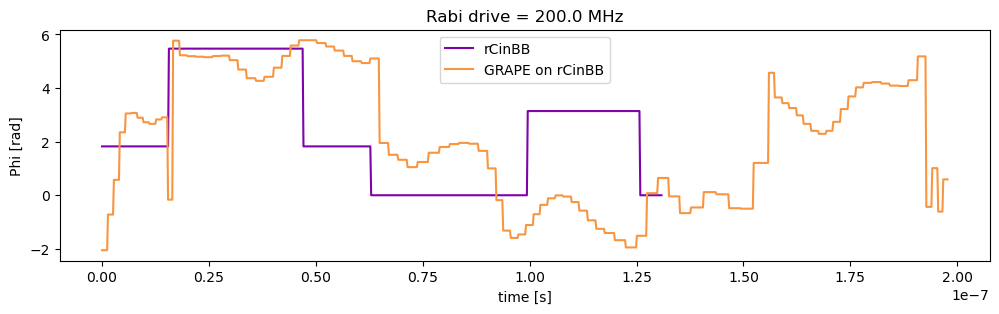

In [6]:
plots = CompositePulsePlots(THETA, PHI, t_ig.detach().clone().numpy(), phi_ig.detach().clone().numpy(), t_history[-1], phi_history[-1])
plots.show_pulse()

### Average gate (in)fidelity heatmaps before and after SAFE-GRAPE

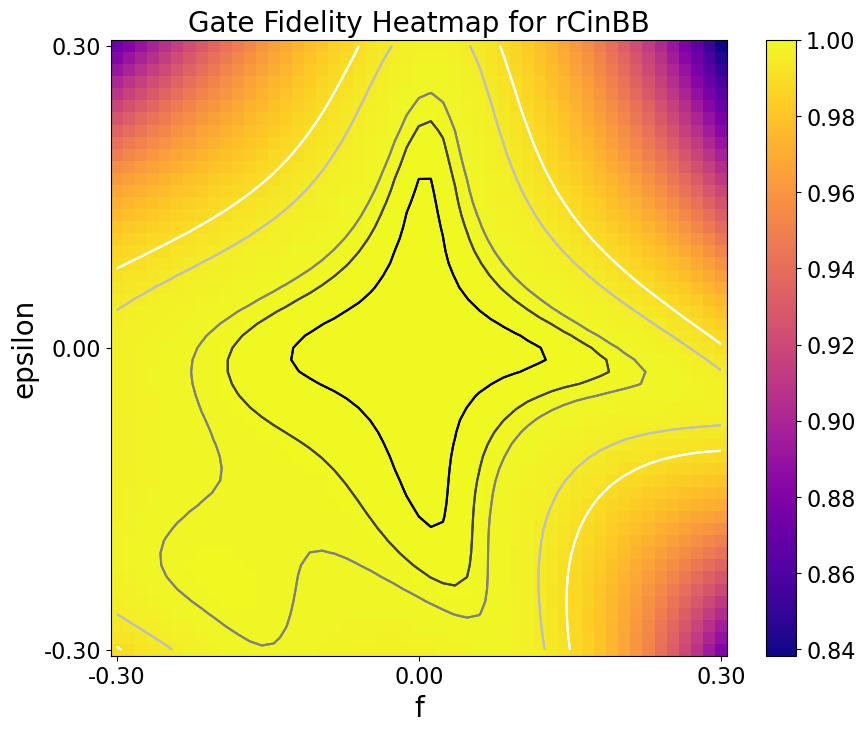

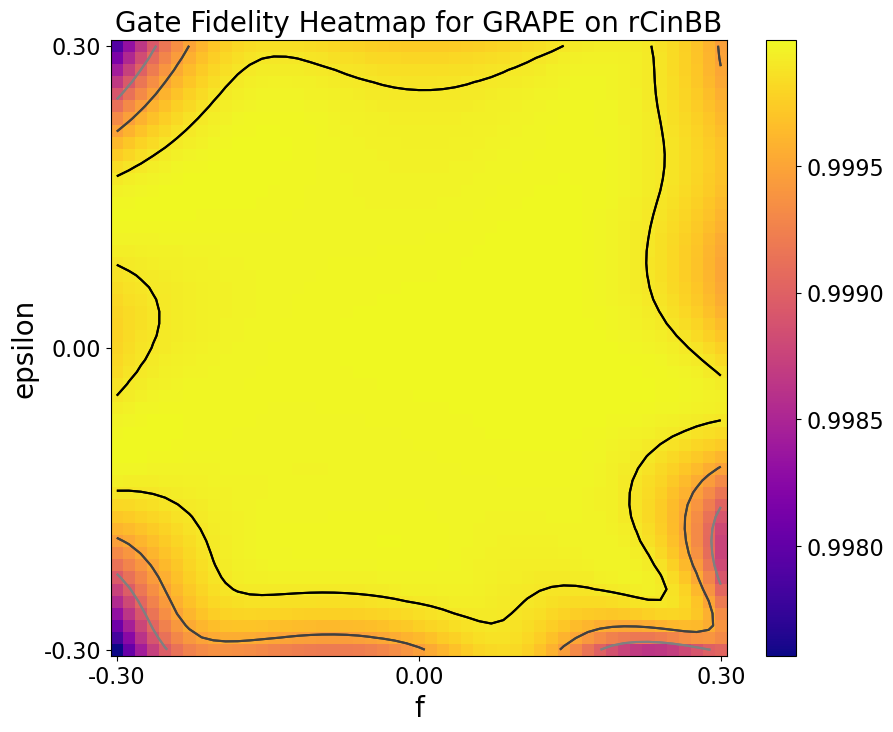

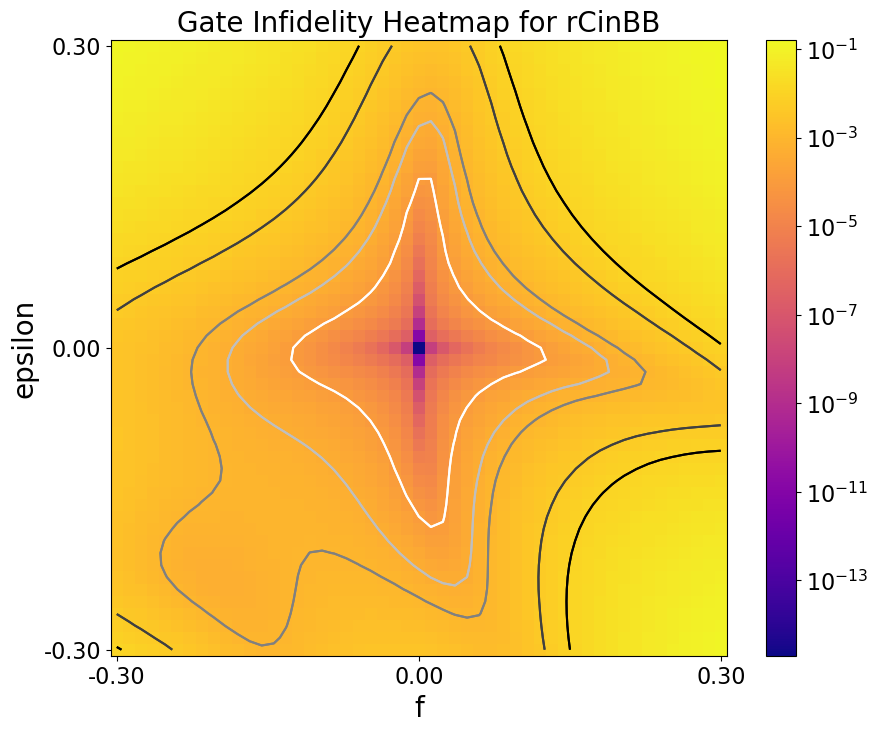

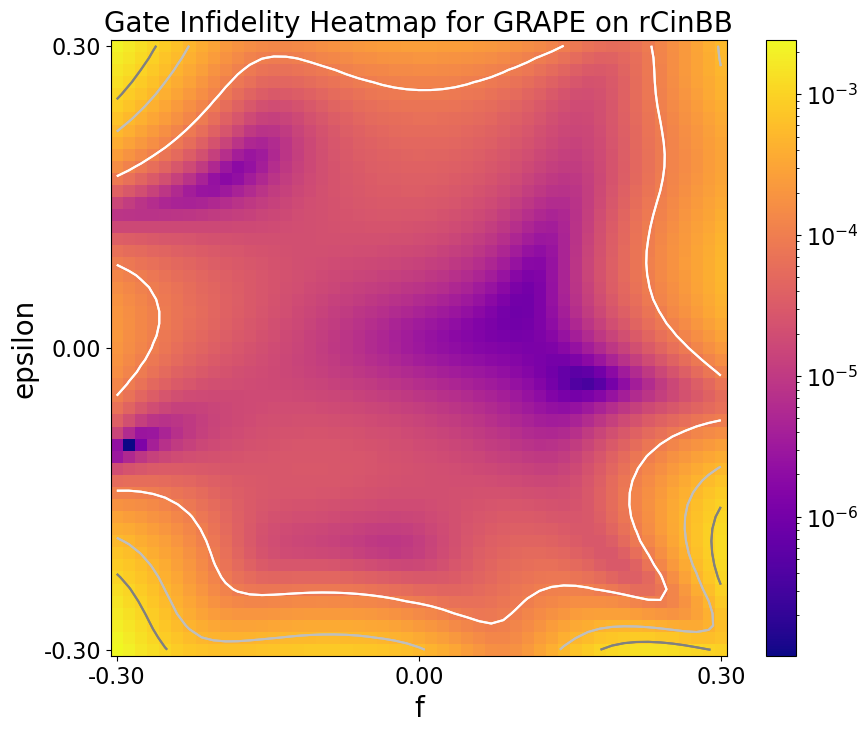

Checking the cumulative infidelity on the fine grid:
rCinBB: 19.181846887415013
GRAPE on rCinBB: 0.18263034242065485


In [7]:
plots.fidelity_heatmap_initial(0.3, 51, 0.3, 51)
plots.fidelity_heatmap_final(0.3, 51, 0.3, 51)
plots.infidelity_heatmap_initial(0.3, 51, 0.3, 51)
plots.infidelity_heatmap_final(0.3, 51, 0.3, 51)

def apply_gaussian_weights(matrix, sigma_epsilon, sigma_f, normalize=True):
    M, N = matrix.shape
    y_coords, x_coords = np.meshgrid(
        np.arange(M),
        np.arange(N))
    center_x = (N - 1) / 2.0
    center_y = (M - 1) / 2.0
    
    gauss_mask = np.exp(-(((x_coords - center_x) ** 2) / (2.0 * sigma_epsilon ** 2) + ((y_coords - center_y) ** 2) / (2.0 * sigma_f ** 2)))

    if normalize: # Normalize mask so that its sum is N*M
        gauss_mask /= gauss_mask.sum()
        gauss_mask *= (M * N)
        
    return matrix * gauss_mask

print('Checking the cumulative infidelity on the fine grid:')
print(f'rCinBB: {np.sum(apply_gaussian_weights(1-plots.fidelity_initial, 51/3, 51/3))}')
print(f'GRAPE on rCinBB: {np.sum(apply_gaussian_weights(1-plots.fidelity_final, 51/3, 51/3))}')

### Action of composite pulse sequence before and after SAFE-GRAPE on the Bloch sphere for initial ground state

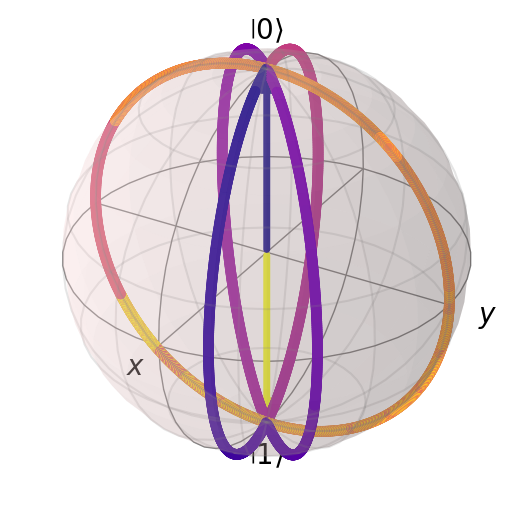

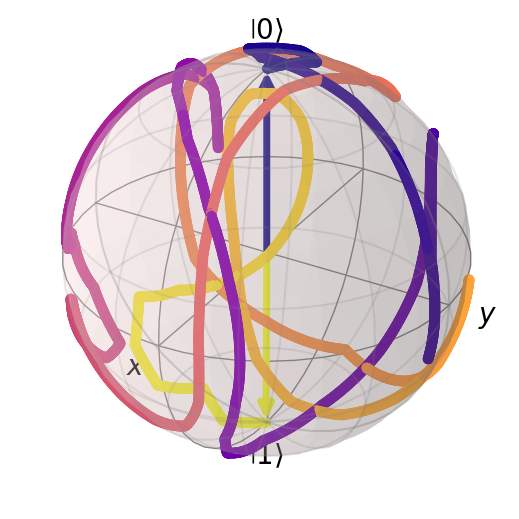

State fidelity rCinBB: 0.9999999999999998
State fidelity GRAPE on rCinBB: 0.9999968662671808


In [8]:
initial_states = plots.initial_pulse_on_blochsphere(filename = 'initial_pulse_on_Blochsphere_eps0_f0.svg')
final_states = plots.final_pulse_on_blochsphere(filename = 'final_pulse_on_Blochsphere_eps0_f0.svg')

print(f'State fidelity rCinBB: {qt.fidelity(qt.sigmax()*initial_states[0], initial_states[-1])}')
print(f'State fidelity GRAPE on rCinBB: {qt.fidelity(qt.sigmax()*final_states[0], final_states[-1])}')

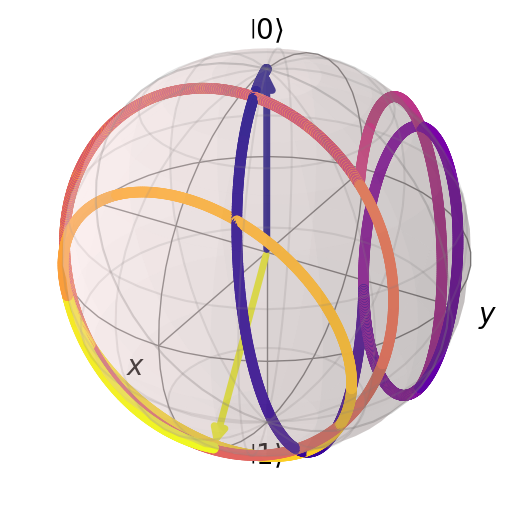

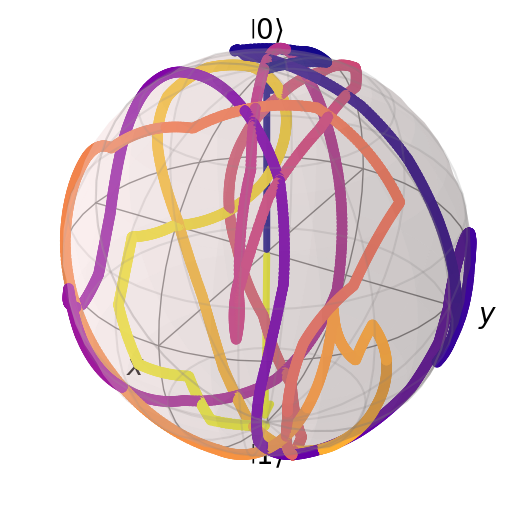

State fidelity rCinBB: 0.9268434827716433
State fidelity GRAPE on rCinBB: 0.9998730062381614


In [9]:
initial_states = plots.initial_pulse_on_blochsphere(epsilon=0.25, f=0.25, filename = 'initial_pulse_on_Blochsphere_eps025_f025.svg')
final_states = plots.final_pulse_on_blochsphere(epsilon=0.25, f=0.25, filename = 'final_pulse_on_Blochsphere_eps025_f025.svg')

print(f'State fidelity rCinBB: {qt.fidelity(qt.sigmax()*initial_states[0], initial_states[-1])}')
print(f'State fidelity GRAPE on rCinBB: {qt.fidelity(qt.sigmax()*final_states[0], final_states[-1])}')